In [1]:
import typing
import os
import os.path as op
import anaconfig

from Preprocessing.preprocessing import load_dataframes

from utils.plotutils.plotconfig import configure_matplotlib
from utils.commonutils.cfeatures import get_unnormalised_features
from scripts.evaluate import (
    get_tracks_from_batch,
    perform_matching,
)

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cudf
import cupy as cp
import cugraph

import scipy.sparse as sps

import montetracko as mt


configure_matplotlib()

INFO:init


In [2]:
indir = "/scratch/acorreia/data/focal-loss-nopid-shared-hits-triplets/track_building_processed/test/velo-sim10b-nospillover"
gnn_indir = "/scratch/acorreia/data/focal-loss-nopid-shared-hits-triplets/metric_learning_processed/test/velo-sim10b-nospillover"
truncated_dir = "/scratch/acorreia/data/__test__/velo-sim10b-nospillover"

In [17]:
for filename in tqdm(os.listdir(indir)[206:]):
    path = os.path.join(indir, filename)
    batch = torch.load(path, map_location="cpu")
    truncated_path = op.join(truncated_dir, f"event{batch.event_str}")

    df_hits_particles = pd.read_parquet(
        truncated_path + "-hits_particles.parquet",
    ).rename(columns={"event": "event_id"})
    df_particles = pd.read_parquet(
        truncated_path + "-particles.parquet",
    ).rename(columns={"event": "event_id"})
    df_tracks = get_tracks_from_batch(batch)
    trackEvaluator = perform_matching(
        df_tracks=df_tracks,
        df_hits_particles=df_hits_particles,
        df_particles=df_particles,
        cure_clones=True,
    )

    df_candidates = trackEvaluator.dataframes["candidates"]
    df_candidates_long_electrons = df_candidates[
        df_candidates["has_velo"] & df_candidates["has_scifi"] & (df_candidates["pid"].abs() == 11)
    ]
    n_tracks_per_particle = df_candidates_long_electrons.groupby("particle_id")["track_id"].count().rename("n_tracks_per_particle")
    df_candidates_long_electrons = df_candidates_long_electrons.merge(
        n_tracks_per_particle,
        on=["particle_id"],
        how="left",
    )
    df_candidates_long_electrons[df_candidates_long_electrons["n_tracks_per_particle"] > 1]
    df_clones = df_candidates_long_electrons[df_candidates_long_electrons["n_tracks_per_particle"] > 1][["track_id", "particle_id"]]
    if df_clones.shape[0]:
        break


  0%|          | 0/794 [00:00<?, ?it/s]

In [21]:
df_clones

track_id  particle_id
2       186         3276
3       189         3208
4       188         3201
5       188         3208
6       189         3201
7       192         3276
8       187         3276

In [22]:
valid_hit_ids = df_hits_particles[df_hits_particles["particle_id"] == 2860]["hit_id"]

In [23]:
df_track = df_tracks[df_tracks["track_id"] == 256].copy()
df_track["valid"]  = df_track["hit_id"].isin(valid_hit_ids)

In [24]:
df_track

Empty DataFrame
Columns: [event_id, hit_id, track_id, valid]
Index: []

In [25]:
cloned_track_ids = df_clones["track_id"].unique()

In [26]:
cloned_unique_hit_ids = df_tracks[df_tracks["track_id"].isin(cloned_track_ids)]["hit_id"].unique()

In [27]:
df_hits_particles[df_hits_particles["hit_id"].isin(cloned_unique_hit_ids)]


run  event_id  plane         x         y        z     hit_id  \
10630207  17196245    476752     12  15.40080   7.23370  125.641  563707891   
10630208  17196245    476752     12  15.40080   7.23370  125.641  563707891   
10630262  17196245    476752     13  17.75370   8.34209  150.641  700034019   
10630263  17196245    476752     13  17.75370   8.34209  150.641  700034019   
10630313  17196245    476752     14  20.08710   9.43103  175.641  702142419   
10630314  17196245    476752     14  20.08710   9.43103  175.641  702142419   
10630359  17196245    476752     15  22.40600  10.50540  200.641  704250051   
10630360  17196245    476752     15  22.40600  10.50540  200.641  704250051   
10630408  17196245    476752     16  24.76380  11.61860  225.641  706358451   
10630409  17196245    476752     16  24.76380  11.61860  225.641  706358451   
10630455  17196245    476752     17  27.10690  12.71730  250.641  574249379   
10630456  17196245    476752     17  27.10690  12.71730  250.641  574249379   
10630503  17196245    476752     18  29.44040  13.80630  275.641  576357779   
10630504  17196245    476752     18  29.44040  13.80630  275.641  576357779   
10630530  17196245    476752     19  -9.48937   9.95606  313.141  577263970   
10630531  17196245    476752     19  -9.48937   9.95606  313.141  577263970   
10630557  17196245    476752     19  34.18510  15.90640  325.641  578477425   
10630558  17196245    476752     19  34.10730  16.06190  325.641  578477684   
10630592  17196245    476752     20 -11.49230  12.03670  388.141  646469677   
10630593  17196245    476752     20 -11.49230  12.03670  388.141  646469677   
10630633  17196245    476752     21 -14.15630  14.85630  486.859  581872097   
10630682  17196245    476752     22 -16.82030  17.59810  586.859  651078299   
10630683  17196245    476752     22 -16.82030  17.59810  586.859  651078299   
10630721  17196245    476752     23 -18.16200  19.01760  636.859  586066808   
10630722  17196245    476752     23 -18.16200  19.01760  636.859  586066808   
10630759  17196245    476752     24 -19.50380  20.43720  686.859  655273044   
10630760  17196245    476752     24 -19.50380  20.43720  686.859  655273044   
10630798  17196245    476752     25 -20.82610  21.83720  736.859  657370417   

          particle_id  n_particles_per_hit  
10630207         3201                    2  
10630208         3208                    2  
10630262         3201                    2  
10630263         3208                    2  
10630313         3201                    2  
10630314         3208                    2  
10630359         3201                    2  
10630360         3208                    2  
10630408         3201                    2  
10630409         3208                    2  
10630455         3201                    2  
10630456         3208                    2  
10630503         3201                    2  
10630504         3208                    2  
10630530         3276                    2  
10630531         3285                    2  
10630557         3208                    1  
10630558         3201                    1  
10630592         3276                    2  
10630593         3285                    2  
10630633         3276                    1  
10630682         3276                    2  
10630683         3285                    2  
10630721         3276                    2  
10630722         3285                    2  
10630759         3276                    2  
10630760         3285                    2  
10630798         3276                    1

In [28]:
def plot_from_track_id(
    track_id: int,
    batch,
    axes=None,
    color="b",
    **kwargs,
):
    candidate_labels = batch.labels
    track_hit_mask = candidate_labels == track_id
    # track_edge_indices = edge_indices[:, track_hit_mask[edge_indices][0]]
    track_un_x = batch.un_x[track_hit_mask].numpy()
    track_un_y = batch.un_y[track_hit_mask].numpy()
    track_un_z = batch.un_z[track_hit_mask].numpy()

    # sort by z
    z_sorting_mask = np.argsort(track_un_z)
    track_un_x = track_un_x[z_sorting_mask]
    track_un_y = track_un_y[z_sorting_mask]
    track_un_z = track_un_z[z_sorting_mask]
    
    track_hit_ids =  batch.hit_id[candidate_labels == track_id]

    if axes is None:
       fig_, axes_ = plt.subplots(1, 2, figsize=(8 * 2, 8))
    else:
        axes_ = axes

    axes_[0].set_xlabel("y")
    axes_[0].set_ylabel("x")
    axes_[1].set_xlabel("z")
    axes_[1].set_ylabel("x")
    axes_[0].plot(
        track_un_y,
        track_un_x,
        color=color,
        marker=".",
        **kwargs,
    )
    axes_[1].plot(
        track_un_z,
        track_un_x,
        color=color,
        marker=".",
        **kwargs,
    )

    if axes is None:
        return fig_, axes_


In [29]:
colors = ["blue", "purple", "violet", "darkorange"]
sizes = [25.0, 20.0, 15.0, 10.0, 5.0]

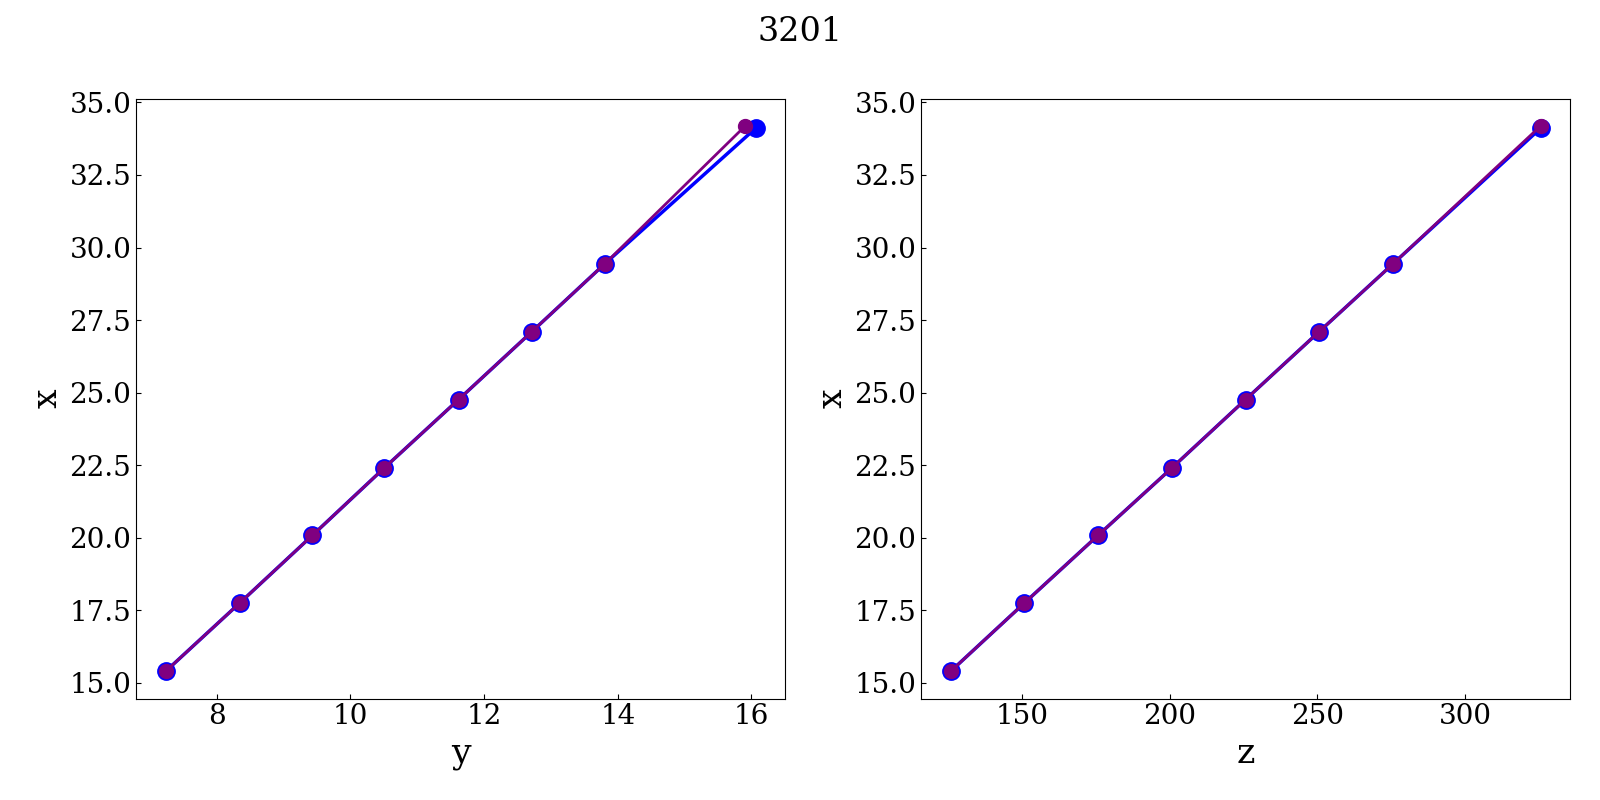

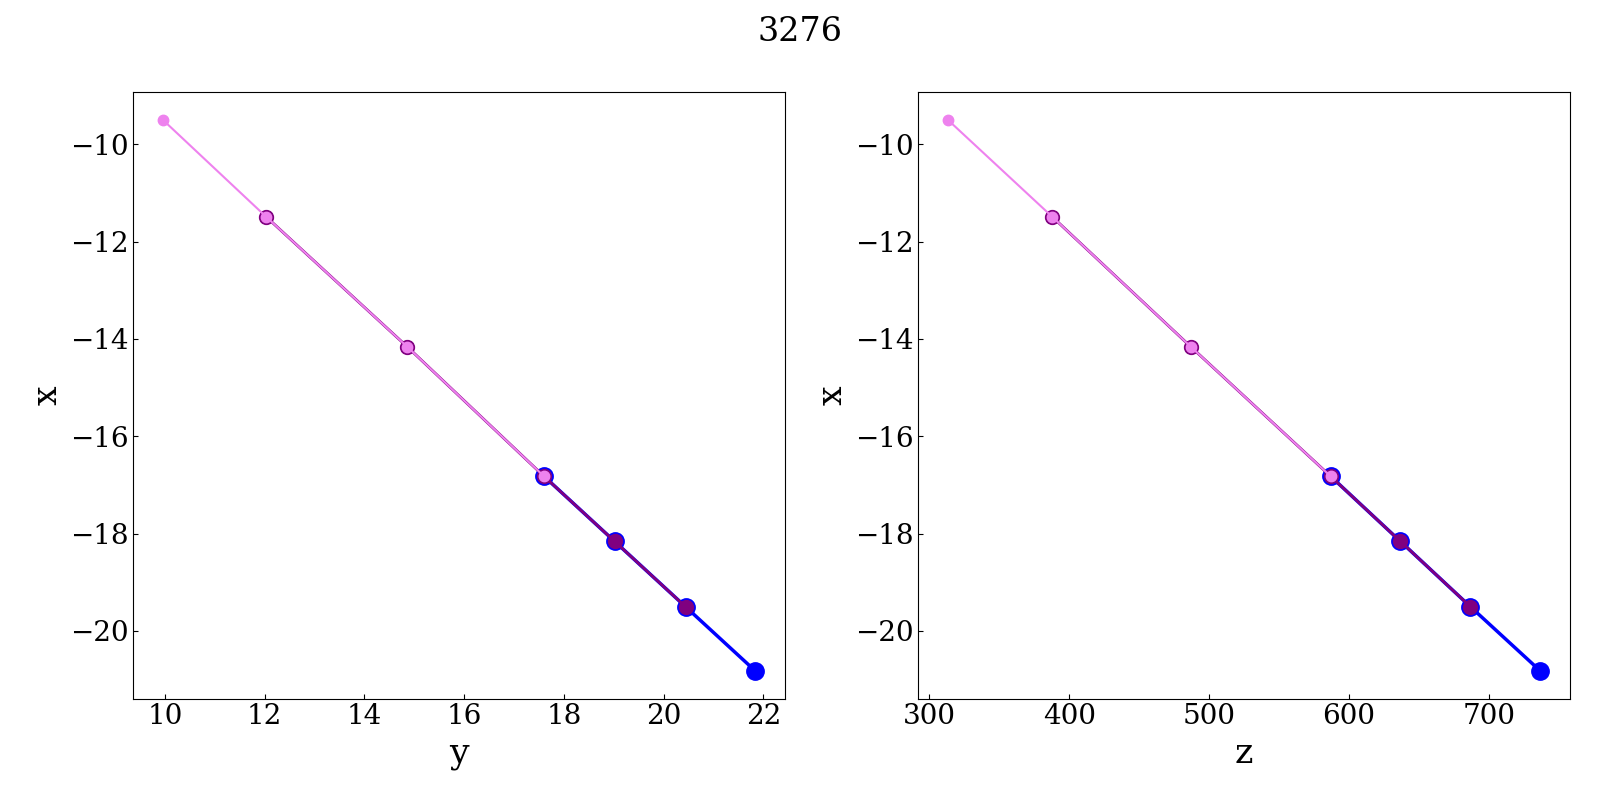

In [30]:
%matplotlib widget

for particle_id, track_id_particle_id in df_clones.groupby("particle_id"):
    track_ids = track_id_particle_id["track_id"]
    fig, axes = plt.subplots(1, 2, figsize=(8 * 2, 8))
    for i, track_id in enumerate(track_ids):
        plot_from_track_id(
            track_id,
            batch,
            axes=axes,
            color=colors[i],
            markersize=sizes[i],
            linewidth=sizes[i] / 10,
        )
    fig.suptitle(str(particle_id))
    fig.tight_layout()


In [25]:
edge_hit_ids = batch_gnn.hit_id[edge_index]
df_edges = pd.DataFrame(
    {
        "hit_id_left": edge_hit_ids[0].cpu().numpy(),
        "hit_id_right": edge_hit_ids[1].cpu().numpy(),
    }
)

In [29]:
df_edges

hit_id_left  hit_id_right
0       766860495     701889798
1       538014694     540116717
2       541229618     543327835
3       707583208     575448253
4       685121534     552667959
...           ...           ...
2568    537233047     539320777
2569    569679009     571777919
2570    539146686     541243085
2571    618004600     754017032
2572    576865784     578957279

[2573 rows x 2 columns]

In [44]:
columns = ["hit_id", "x", "y", "z"]
track_hit_ids = df_tracks[df_tracks["track_id"] == 640]["hit_id"]
df_edges_of_interest = df_edges[
    df_edges["hit_id_left"].isin(track_hit_ids)
    | df_edges["hit_id_right"].isin(track_hit_ids)
]
for side in ["left", "right"]:
    df_edges_of_interest = df_edges_of_interest.merge(
        df_hits_particles[columns].rename(
            columns={
                column: f"{column}_{side}"
                for column in columns
            }
        ).drop_duplicates([f"hit_id_{side}"]),
        on=f"hit_id_{side}",
        how="left",
    )


In [45]:
df_edges_of_interest = df_edges_of_interest.sort_values(["z_right", "z_left"])[["hit_id_left", "hit_id_right", "z_left", "z_right"]]

In [46]:
new_indices = np.unique(
    np.concatenate((df_edges_of_interest["hit_id_left"], df_edges_of_interest["hit_id_right"])),
    return_inverse=True
)[1]
df_edges_of_interest["idx_left"] = new_indices[:df_edges_of_interest.shape[0]]
df_edges_of_interest["idx_right"] = new_indices[df_edges_of_interest.shape[0]:]

In [47]:
df_edges_of_interest

hit_id_left  hit_id_right   z_left  z_right  idx_left  idx_right
3     632481496     567474869  149.359  174.359         8          0
10    632481496     702088446  149.359  175.641         8          9
1     567474869     569977323  174.359  200.641         0          2
5     567474869     569976554  174.359  200.641         0          1
7     702088446     569976554  175.641  200.641         9          1
11    702088446     569977323  175.641  200.641         9          2
2     569977323     572083416  200.641  225.641         2          3
0     572083416     574189764  225.641  250.641         3          4
9     574189764     576295856  250.641  275.641         4          5
6     576295856     578411145  275.641  325.641         5          6
4     578411145     580534861  325.641  400.641         6          7
8     580534861     716976376  400.641  499.359         7         10

In [135]:
from GNN.models.triplet_interaction_gnn import (
    TripletInteractionGNN,
    correct_shared_hits_triplets,
)
from scripts.track_building import (
    get_filtered_triplet_indices,
    count_occurences,
    swap_values_in_tensor,
    get_edge_indices_not_in_triplets,
    build_tracks_from_triplets,
    cure_max_triplet_index,
)


gnn_artifact_path= "../artifacts/gnn/focal-loss-nopid-shared-hits-triplets/version_9/checkpoints/epoch=99-step=750000.ckpt"
gnn_model = TripletInteractionGNN.load_from_checkpoint(
    gnn_artifact_path,
    map_location="cuda",
    # hparams=load_config(CONFIG)["gnn"],
)
gnn_model.hparams["edge_score_cut"] = 0.6

In [9]:
batch_gnn = torch.load(op.join(gnn_indir, batch.event_str)).cuda()
batch_gnn = correct_shared_hits_triplets(batch_gnn)

In [10]:
batch_gnn.x.device.type

'cuda'

In [11]:
output = gnn_model.shared_evaluation(batch_gnn, log=False)
triplet_indices = output["triplet_indices"]
triplet_scores = output["triplet_scores"]
edge_index = output["edge_index"]

In [12]:
triplet_score_cut = 0.2

In [13]:
triplet_index, forked_triplet_index = get_filtered_triplet_indices(
    triplet_indices,
    triplet_scores,
    edge_index,
    triplet_score_cut,
)
triplet_index, forked_triplet_index = cure_max_triplet_index(
    edge_index=edge_index,
    triplet_index=triplet_index,
    forked_triplet_index=forked_triplet_index,
)

# Weakly Connected Component Algorithm applied on edges (instead of hits)
# Multiple triplets sharing the same central hit are not considered in this
# first step
df_triplet_index = cudf.DataFrame(
    {
        "source": cp.asarray(triplet_index[0]),
        "destination": cp.asarray(triplet_index[1]),
    }
)
graph = cugraph.from_cudf_edgelist(df_triplet_index, renumber=False)
df_labels = cugraph.weakly_connected_components(graph).rename(
    columns={
        "vertex": "edge_idx",
        "labels": "track_id",
    },
)
_, indices = cp.unique(df_labels["track_id"].to_cupy(), return_inverse=True)
df_labels["track_id"] = indices

In [14]:
df_remaining_triplets = cudf.DataFrame(
    {
        "edge_idx_left": cp.asarray(forked_triplet_index[0]),
        "edge_idx_right": cp.asarray(forked_triplet_index[1]),
        "central_hit_idx": cp.asarray(edge_index[1][forked_triplet_index[0]]),
    }
)
for side in ["left", "right"]:
    df_remaining_triplets = df_remaining_triplets.merge(
        df_labels.rename(
            columns={"edge_idx": f"edge_idx_{side}", "track_id": f"track_id_{side}"}
        ),
        how="left",
        on=f"edge_idx_{side}",
    )

df_track_links = df_remaining_triplets.drop_duplicates(
    ["central_hit_idx", "track_id_left", "track_id_right"]
)
# First consider links that are effectively not a fork
df_track_links["fork"] = count_occurences(
    df_track_links["central_hit_idx"].to_cupy()
)

df_track_links_wo_fork = df_track_links[df_track_links["fork"] == 1][
    ["track_id_left", "track_id_right"]
]
df_track_links_with_fork = df_track_links[df_track_links["fork"] >= 2][
    ["track_id_left", "track_id_right"]
]
track_id_max = df_labels["track_id"].max()
track_id_wo_fork_max = df_track_links_wo_fork.max().max()

swap_values_in_tensor(df_labels["track_id"], track_id_max, track_id_wo_fork_max)
swap_values_in_tensor(
    df_track_links_wo_fork["track_id_left"], track_id_max, track_id_wo_fork_max
)
swap_values_in_tensor(
    df_track_links_wo_fork["track_id_right"], track_id_max, track_id_wo_fork_max
)

df_new_labels = cugraph.weakly_connected_components(
    cugraph.from_cudf_edgelist(
        df_track_links_wo_fork,
        source="track_id_left",
        destination="track_id_right",
        renumber=False,
    )
).rename(
    columns={
        "vertex": "old_track_id",
        "labels": "track_id",
    }
)

# affect the new labels to `df_labels`
df_labels = cudf.merge(
    df_labels.rename(columns={"track_id": "old_track_id"}),
    df_new_labels,
    how="left",
)[["edge_idx", "track_id"]]

# affect the new labels to `df_track_links_with_fork`
for side in ["left", "right"]:
    df_track_links_with_fork = cudf.merge(
        df_track_links_with_fork.rename(
            columns={f"track_id_{side}": f"old_track_id_{side}"}
        ),
        df_new_labels.rename(
            columns={
                "old_track_id": f"old_track_id_{side}",
                "track_id": f"track_id_{side}",
            }
        ),
        on=f"old_track_id_{side}",
    )[["track_id_left", "track_id_right"]]


In [15]:
# Each forked link will be associated with a new track whose ``track_id``
# is given by a new column ``new_track_id``
max_track_id = df_labels["track_id"].max()
df_track_links_with_fork["new_track_id"] = cp.arange(
    max_track_id + 1,
    max_track_id + df_track_links_with_fork.shape[0] + 1,
)

# Build the new tracks
# This will copy the edges
df_track_links_with_fork_melted = df_track_links_with_fork.melt(
    id_vars=["new_track_id"],
    value_vars=["track_id_left", "track_id_right"],
    value_name="track_id",
    var_name="column",
)
track_ids_to_copy = cp.unique(
    df_track_links_with_fork[["track_id_left", "track_id_right"]].to_cupy()
)


In [16]:
df_track_links_with_fork

track_id_left  track_id_right  new_track_id
0             327             498           622
1             447             510           623
2              57             443           624
3             141             448           625
4             183             463           626
5             183             463           627
6             296             546           628
7               5             260           629
8              57             222           630
9             490              29           631
10            447             403           632
11              5              33           633
12            327             100           634
13            183             259           635
14            183             259           636
15            296             301           637
16            490             286           638
17            425             316           639
18             58             152           640
19            322             152           641

In [17]:
df_track_links_with_fork[df_track_links_with_fork["track_id_right"] == 459]

Empty DataFrame
Columns: [track_id_left, track_id_right, new_track_id]
Index: []

In [18]:
df_track_links_wo_fork[
    df_track_links_wo_fork["track_id_right"] == 287
]

Empty DataFrame
Columns: [track_id_left, track_id_right]
Index: []

In [19]:
torch.arange(batch_gnn.hit_id.shape[0], device="cuda")[batch_gnn.hit_id == 572083416]

tensor([593], device='cuda:0')

In [20]:
torch.arange(edge_index.shape[1], device="cuda")[(edge_index == 593).sum(axis=0).bool()]

tensor([134, 594], device='cuda:0')

In [21]:
df_labels[df_labels["edge_idx"] == 133]


edge_idx  track_id
469       133        53

In [22]:
df_labels[df_labels["track_id"] == 459]

edge_idx  track_id
55        1127       459
304       2112       459
1816      1848       459

In [23]:
batch_gnn_processed.hit_id

NameError: name 'batch_gnn_processed' is not defined

In [ ]:
batch.hit_id.cuda()[batch_gnn_processed.labels == torch.tensor(640, device=batch_gnn_processed.labels.device)]

In [24]:
batch.hit_id.cuda()[batch_gnn_processed.labels == torch.tensor(641, device=batch_gnn_processed.labels.device)]

NameError: name 'batch_gnn_processed' is not defined

In [267]:
df_tracks[df_tracks["track_id"] == 640]

tensor([623411093, 588910375, 543346118,  ..., 545828083, 547901800,
        565346045])

In [293]:
track_ids = batch_gnn_processed.labels[batch_gnn_processed.hit_id.cuda() == 572083416]

In [295]:
track_ids

tensor([633, 634], device='cuda:0')

In [296]:
for track_id in track_ids:
    print(batch_gnn_processed.hit_id.cuda()[batch_gnn_processed.labels == track_id])

tensor([574189764, 716976376, 580534861, 576295856, 578411145, 567474869,
        572083416, 569977323, 702088446, 632481496], device='cuda:0')
tensor([574189764, 716976376, 580534861, 576295856, 578411145, 567474869,
        572083416, 569977323, 702088446, 632481496], device='cuda:0')
